In [1]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [2]:
data_source = 'kaggle' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '<your API key>'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')


FileNotFoundError: [Errno 2] No such file or directory: 'Stocks\\hpq.us.txt'

In [9]:
df = pd.read_csv('GOLD60_coladded.csv', index_col=0)

In [10]:
df

,Date,Time,Open,High,Low,Close,Volume,Date_Time
0,2016-05-23 23:00:00,23:00,1249.34,1249.67,1248.60,1248.86,1253,2016.05.23 23:00
1,2016-05-24 01:00:00,01:00,1248.83,1250.04,1248.31,1249.73,1149,2016.05.24 01:00
2,2016-05-24 02:00:00,02:00,1249.71,1249.71,1248.44,1249.44,1432,2016.05.24 02:00
3,2016-05-24 03:00:00,03:00,1249.43,1252.09,1245.65,1248.26,4575,2016.05.24 03:00
4,2016-05-24 04:00:00,04:00,1248.25,1249.07,1246.63,1247.95,4660,2016.05.24 04:00
...,...,...,...,...,...,...,...,...
15197,2023-06-05 03:00:00,03:00,1949.30,1949.42,1945.58,1946.40,9406,2023.06.05 03:00
15198,2023-06-05 04:00:00,04:00,1946.39,1948.27,1945.67,1947.47,21640,2023.06.05 04:00
15199,2023-06-05 05:00:00,05:00,1947.45,1948.23,1943.89,1944.82,14289,2023.06.05 05:00
15200,2023-06-05 06:00:00,06:00,1944.83,1947.44,1944.24,1947.04,9693,2023.06.05 06:00


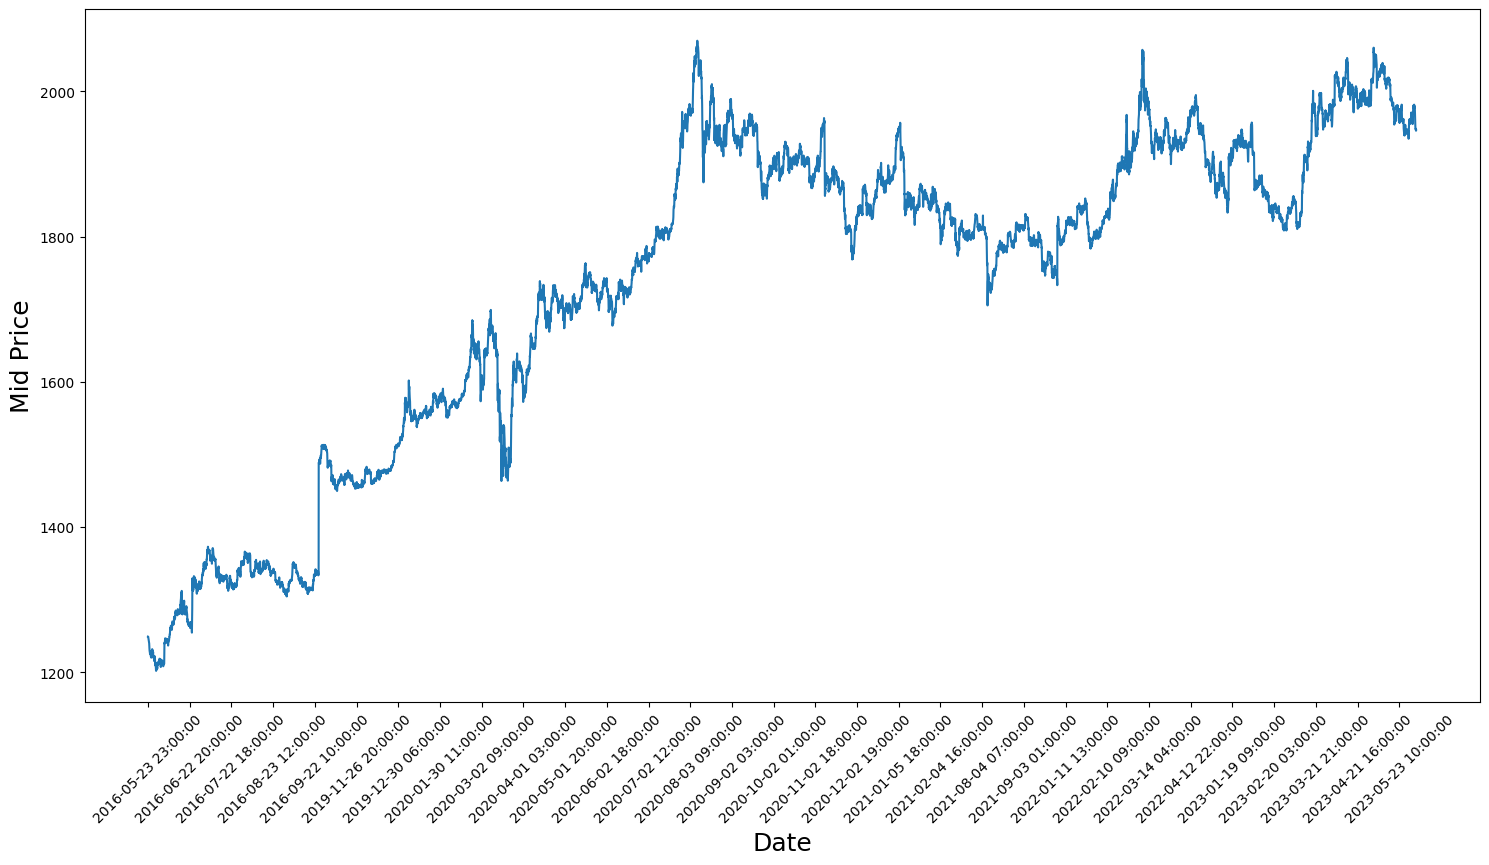

In [11]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()


In [13]:
#Splitting Data into a Training set and a Test set
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices+low_prices)/2.0


In [25]:
len(df)

15202

In [36]:
d_len = int(len(df)*0.80)

train_data = mid_prices[:d_len]
test_data = mid_prices[d_len:]


In [37]:
# Normalizing the Data
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [38]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [39]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [40]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

## One-Step Ahead Prediction via Averaging

In [41]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00487


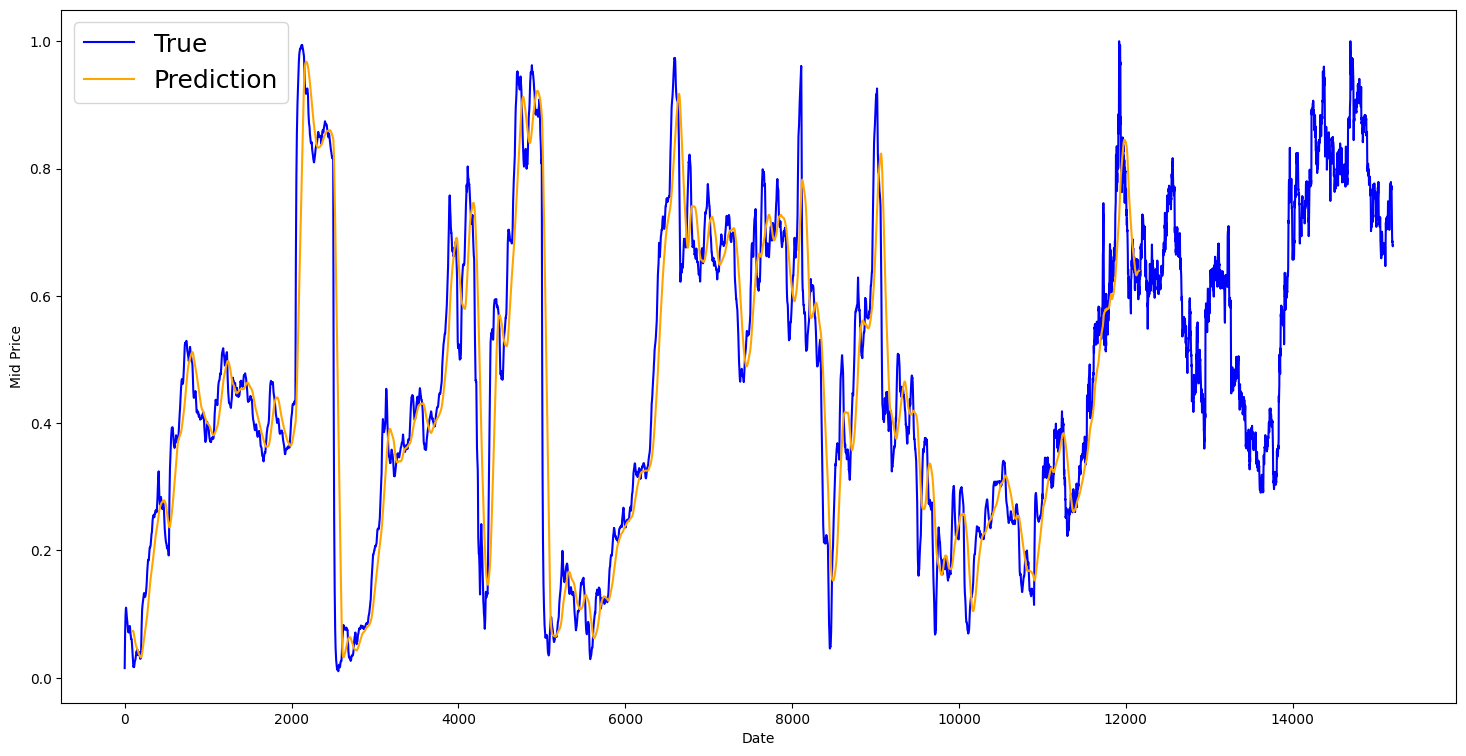

In [42]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

## Exponential Moving Average

In [43]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00004


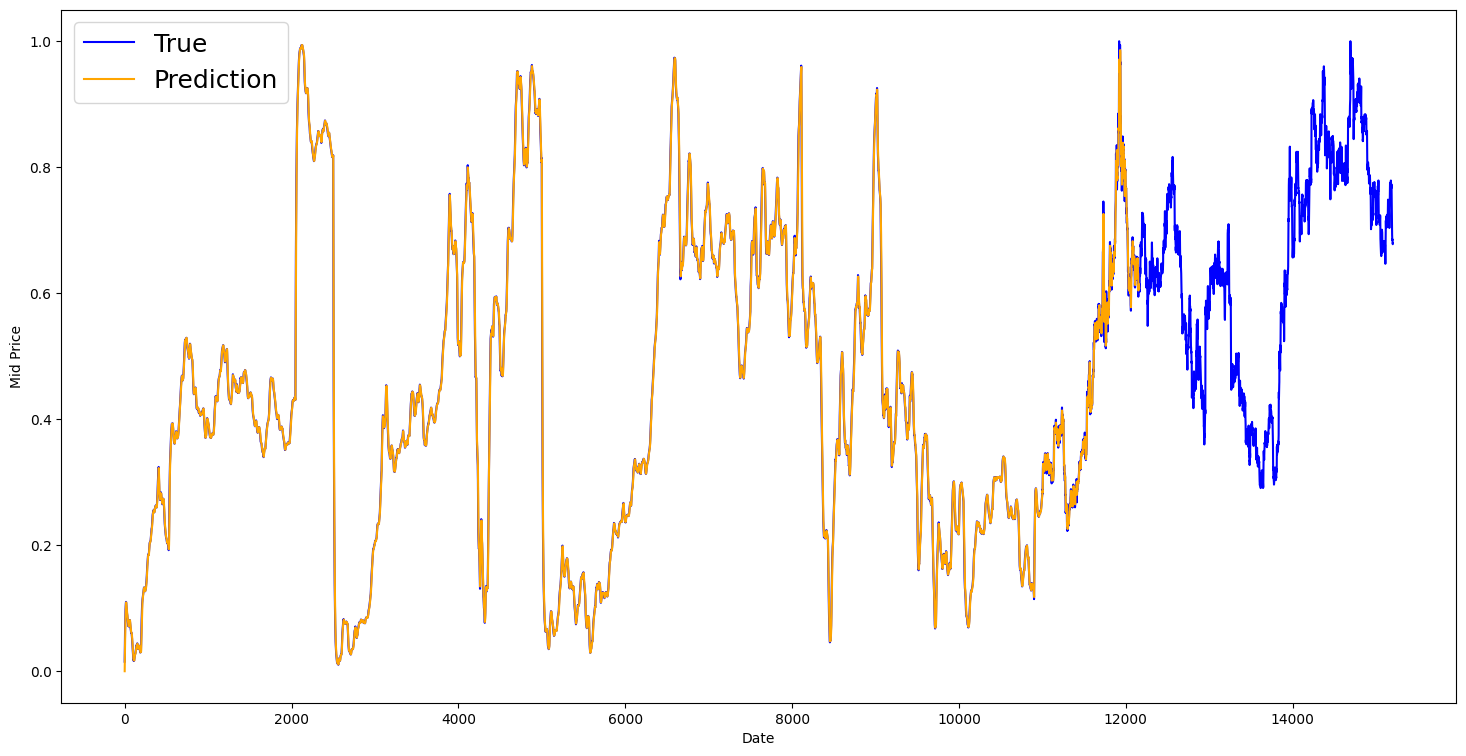

In [44]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

## (say you predict the next 2 days window, instead of just the next day). 
## Then you will realize how wrong EMA can go. 

## Introduction to LSTMs: Making Stock Movement Predictions Far into the Future